In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# reading data file
df = pd.read_csv('/content/drive/MyDrive/Data-NLP/WELFake_Dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
df.columns = ["id","title","text","label"]

In [ ]:
df.head()

,id,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      72134 non-null  int64 
 1   title   71576 non-null  object
 2   text    72095 non-null  object
 3   label   72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Preprocessing and feature extraction

In [ ]:
# read in our data and preprocess it

df.drop(labels=['id','title'], axis='columns', inplace=True)


In [ ]:
df['text']

0        No comment is expected from Barack Obama Membe...
1           Did they post their votes for Hillary already?
2         Now, most of the demonstrators gathered last ...
3        A dozen politically active pastors came here f...
4        The RS-28 Sarmat missile, dubbed Satan 2, will...
                               ...                        
72129    WASHINGTON (Reuters) - Hackers believed to be ...
72130    You know, because in fantasyland Republicans n...
72131    Migrants Refuse To Leave Train At Refugee Camp...
72132    MEXICO CITY (Reuters) - Donald Trump’s combati...
72133    Goldman Sachs Endorses Hillary Clinton For Pre...
Name: text, Length: 72134, dtype: object

In [ ]:
df.dropna(subset = ["text"], inplace=True)

In [ ]:
# Removing stopwords

from gensim.parsing.preprocessing import remove_stopwords
def stopword_removal(row):
    text = row['text']
    text = remove_stopwords(text)
    return text

In [ ]:
df['text'] = df.apply(stopword_removal, axis=1)

In [ ]:
# Converting text into smaller letters.

df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

<ipython-input-95-b3aba37379ec>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 72095 texts.


In [ ]:
texts = texts.fillna("")

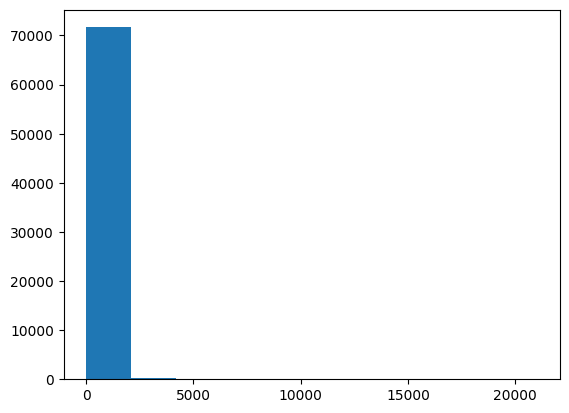

In [ ]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [ ]:
MAX_SEQUENCE_LENGTH = 700
MAX_NUM_WORDS = 1000
EMBEDDING_DIM = 64
TEST_SPLIT = 0.2

In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# vectorize the text samples into a 2D integer tensor 

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences


# tokenizing sentences into words 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(texts)
# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(texts)

# calculating word_index
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
# padding data to the same length for each samples
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 242766 unique tokens.
Shape of data tensor: (72095, 700)
Shape of label tensor: (72095,)


# Data Curation Phase

In [ ]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split



x, x_test, y, y_test = train_test_split(data, 
                                        labels, 
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y, 
                                                  test_size=0.1)

In [ ]:
x_train.shape

(51908, 700)

In [ ]:
x_val.shape

(5768, 700)

In [ ]:
x_test.shape

(14419, 700)

# Model Building Phase

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import RMSprop

#defining dropout layers
dropout1 = 0.4
dropout2 = 0.5
num_classes = 1

model = Sequential([
    # part 1: word and sequence processing
    # defining embedding layer where embedding dimension/ vector size is defined as 64 and input length is set as 700. Where num_words are unique words.
    layers.Embedding(242766,
              EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True), #although keras suggest to keep this value false to avoid weights getting updated during training phase, turning it true made a huge impact on model accuracy
    # for defining convolutional layer, number of filters are set as 64 and kernal size is defined as 1 X 5.
    layers.Conv1D(64, 5, activation='relu'),
    # maxpooling1d layer is used to take maximum values from representation.
    layers.MaxPooling1D(2),
    # adding dropout 0.4
    layers.Dropout(dropout1),

     # creating second convolutional layer with kernal size 1 X 3, and number of filters will be 32. Where activation function will remain same as ReLU.    
    layers.Conv1D(32, 3, activation='relu'),
    # creating maxpooling layer with 2 neurons so that will compare with neighbour neuron and will take max value.
    layers.MaxPooling1D(2, strides=2),
    
    #adding another Long Short Term Memory layer to help the model detect dependencies on the sequencial data with 64 units which is dimentionality of output space
    layers.LSTM(64),

    # part 2: classification
  
    # dense layer with 256 neurons and  Relu activation function.
    layers.Dense(256, activation='relu'),
    # dropout value is 0.5
    layers.Dropout(dropout2),
    # output layer contains 1 values because this is binary classification problem.
    # Where activation function is 'sigmoid' because it will calculate probability of each nuerons individually and whichever nueron has highest value that will be selected.
    layers.Dense(num_classes, activation='sigmoid')
])

# compiling the model with loss as categorical_crossentropy because this is multiclass classfication problem.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 700, 64)           15537024  
                                                                 
 conv1d_30 (Conv1D)          (None, 696, 64)           20544     
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 348, 64)          0         
 g1D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 348, 64)           0         
                                                                 
 conv1d_31 (Conv1D)          (None, 346, 32)           6176      
                                                                 
 max_pooling1d_31 (MaxPoolin  (None, 173, 32)          0         
 g1D)                                                

In [ ]:
# visalizing the layers of model.
import tensorflow as tf

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

# Model Training Phase

In [ ]:
# train the model with batch size of 128 and 15 epochs.
import time as t
start = t.time()
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=25,
                    validation_data=(x_val, y_val))

print("total training time:",t.time()-start)

Epoch 1/25
406/406 [==============================] - 10s 25ms/step - loss: 0.0443 - accuracy: 0.9837 - val_loss: 0.0980 - val_accuracy: 0.9674
Epoch 2/25
406/406 [==============================] - 10s 24ms/step - loss: 0.0341 - accuracy: 0.9880 - val_loss: 0.1102 - val_accuracy: 0.9655
Epoch 3/25
406/406 [==============================] - 9s 23ms/step - loss: 0.0309 - accuracy: 0.9892 - val_loss: 0.1104 - val_accuracy: 0.9690
Epoch 4/25
406/406 [==============================] - 9s 22ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.1240 - val_accuracy: 0.9664
Epoch 5/25
406/406 [==============================] - 10s 24ms/step - loss: 0.0228 - accuracy: 0.9921 - val_loss: 0.1106 - val_accuracy: 0.9710
Epoch 6/25
406/406 [==============================] - 10s 24ms/step - loss: 0.0197 - accuracy: 0.9927 - val_loss: 0.1188 - val_accuracy: 0.9678
Epoch 7/25
406/406 [==============================] - 9s 23ms/step - loss: 0.0183 - accuracy: 0.9930 - val_loss: 0.1314 - val_accuracy: 0.

In [ ]:
!pip install keras_flops

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [ ]:
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

In [ ]:
# calculating flops
flops = get_flops(model, batch_size = 128)
print(flops)
print(f"FLOPS: {flops / 10 ** 9:.03} G ")

4211785856
FLOPS: 4.21 G 


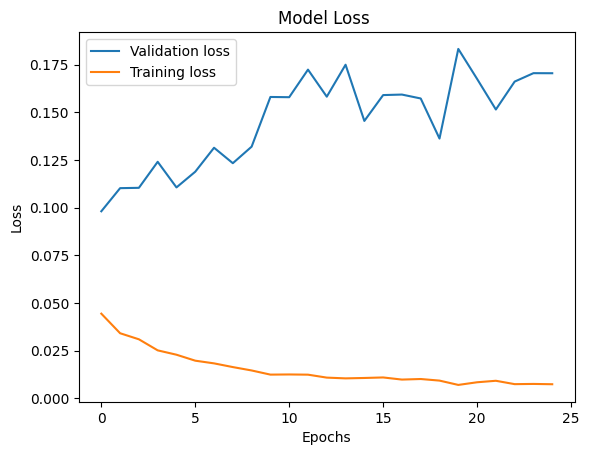

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Validation loss', 'Training loss'], loc='upper left')
plt.show()

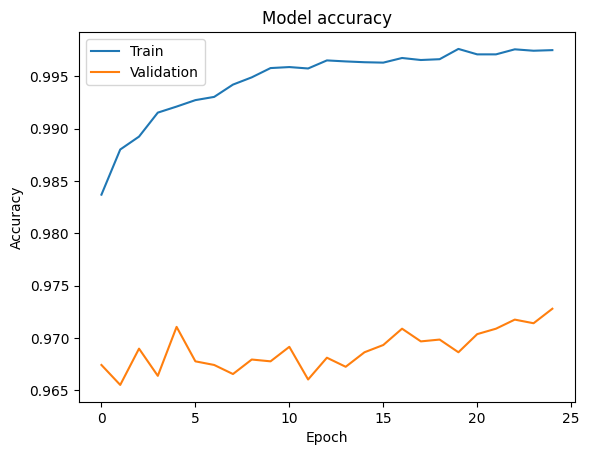

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing Phase

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
451/451 [==============================] - 2s 5ms/step - loss: 0.1767 - accuracy: 0.9700
test loss, test acc: [0.17674410343170166, 0.9700395464897156]


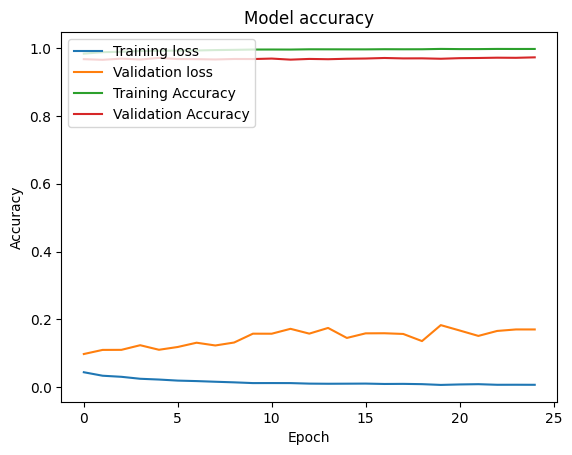

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'], loc='upper left')
plt.show()

# Evaluation Phase

In [ ]:
# define a function that allows us to evaluate models

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve



def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    
    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'CNN')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% 'CNN',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

451/451 [==============================] - 2s 4ms/step


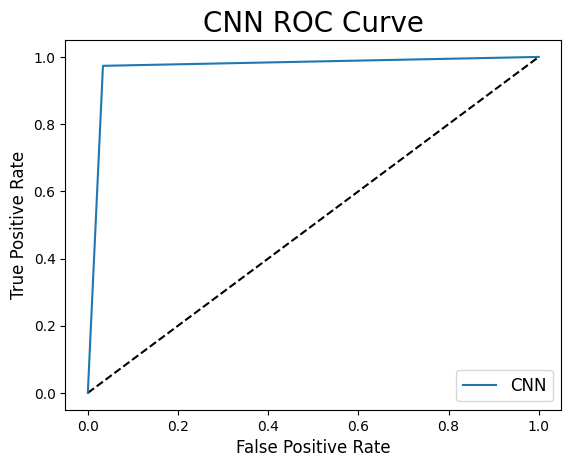

Training Accuracy: 99.98%
Testing Accuracy: 97.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      7060
           1       0.97      0.97      0.97      7359

    accuracy                           0.97     14419
   macro avg       0.97      0.97      0.97     14419
weighted avg       0.97      0.97      0.97     14419

AUC score 0.9699662146946157
Total time required for testing 10.514982223510742


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)